# Import packages

In [4]:
import torch
import torchvision.datasets as dsets
from torch.autograd import Variable
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix

In [5]:
# Change working directory
import os
os.chdir('/content/drive/My Drive/UOttawa/2020Fall/CSI5138/assignment2')

# Define Networks

## Logistic Regression
Parameters are the size of input and output.

In [6]:
# Define the logistic regression
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)


    def forward(self, x):
        outputs = self.linear(x)
        return outputs

## MLP
The parameters are the size of input layer and output layer.

I have tested three different network structures, one simple network,
one with wider hidden layer and another deeper one, to see how the 
width and deepth would affect the learning process and result.

Here are these three network (Take CIFAR-10 dataset as example, the number
is the size of each layer):
* CIFAR 3072 -> 512 -> 128 -> 10
* CIFAR 3072 -> 1024 -> 512 -> 10
* CIFAR 3072 -> 512 -> 256 -> 128 -> 10

In [7]:
# Define a 3 layer MLP 28*28 -> 512 -> 128 -> 10
# CIFAR 3072 -> 512 -> 128 -> 10
# CIFAR 3072 -> 1024 -> 512 -> 10
# CIFAR 3072 -> 512 -> 256 -> 128 -> 10
class MLP(torch.nn.Module):
  def __init__(self, input_dim, output_dim):
    super(MLP, self).__init__()
    self.input_dim = input_dim
    #Original network
    self.fc1 = torch.nn.Linear(input_dim, 512)
    self.fc2 = torch.nn.Linear(512, 128)
    self.fc3 = torch.nn.Linear(128, output_dim)

    # Experiment 1
    # self.fc1 = torch.nn.Linear(input_dim, 1028)
    # self.fc2 = torch.nn.Linear(1028, 512)
    # self.fc3 = torch.nn.Linear(512, output_dim)

    # Experiment 2
    self.fc1 = torch.nn.Linear(input_dim, 512)
    self.fc2 = torch.nn.Linear(512, 256)
    self.fc3 = torch.nn.Linear(256, 128)
    self.fc4 = torch.nn.Linear(128, output_dim)
  
  
  def forward(self, x):
    x = x.view(-1, self.input_dim)
    output = F.relu(self.fc1(x))
    output = F.relu(self.fc2(output))
    output = F.relu(self.fc3(output))
    return F.softmax(self.fc4(output))

print(MLP(784, 10))

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


## CNN
The parameter is the type of dataset. It will affact the number of 
channels of the input layer and also the size of the first fully connected
layer.

I have done two experiments on the structure.

* Two convolution layers and two fc layers.
* Two convolution layers and three fc layers.

In [8]:
class Net(torch.nn.Module):
  def __init__(self, dataset='mnist'):
    super(Net, self).__init__()
    self.dataset = dataset


    # The original network
    # if dataset=='mnist':
    #   self.conv1 = torch.nn.Conv2d(1, 10, 5)
    #   self.fc1 = torch.nn.Linear(320, 50)
    # else: 
    #   self.conv1 = torch.nn.Conv2d(3, 10, 5)
    #   self.fc1 = torch.nn.Linear(500, 50)
    # self.conv2 = torch.nn.Conv2d(10, 20, 5)
    # self.fc2 = torch.nn.Linear(50, 10)


    # Experiment 1: add one more fc layer
    if dataset=='mnist':
      self.conv1 = torch.nn.Conv2d(1, 10, 5)
      self.fc1 = torch.nn.Linear(320, 50)
    else: 
      self.conv1 = torch.nn.Conv2d(3, 10, 5)
      self.fc1 = torch.nn.Linear(500, 250)
    self.conv2 = torch.nn.Conv2d(10, 20, 5)
    self.fc2 = torch.nn.Linear(250, 50)
    self.fc3 = torch.nn.Linear(50, 10)
  

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    if self.dataset=='mnist':
      x = x.view(-1, 320)
    else:
      x = x.view(-1, 500)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.softmax(x)

print(Net())

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc2): Linear(in_features=250, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


# The main class ***play***
This class is the main class to play with all the networks and 
parameters. 

The parameters needed to initialize the class is:
* dataset - the type of dataset
* method - the model's name
* epochs - the number of epochs

There are two functions to load dataset -- ***load_data_mnist()*** and ***load_data_cifar()***. The first one is to load MNIST and the second one is to load CIFAR-10. 

The following function ***imshow()*** is to visualize the examples in MNIST.

The next one is ***define_constants()***. It initializes some variables of the model based on the model we want to use, like input size, learning rate, the model, criterion and optimizer.

After that is the learning and testing function, ***train()***. It iterate all the training data batches for *epochs* times, do the learning things, compute the loss and update the weights. Then in every 100 times, it will compute and collect the accuracy of the test data. 

Then plot the figures of the loss and accuracy after all the training.

In [9]:
class play:
  def __init__(self, dataset, method, epochs=5):
    self.method = method
    self.batch_size = 100
    self.dataset = dataset
    self.epochs = epochs
    if dataset == 'mnist':
      self.load_data_mnist()
    else:
      self.load_data_cifar()
    self.define_constants(method)


  def load_data_mnist(self):
    # Each image is 28*28, the training set contains 60000 examples, and the test set 10000 examples.
    self.train_dataset = dsets.MNIST(root='./MNIST', train=True, transform=transforms.ToTensor(), download=True)
    self.test_dataset = dsets.MNIST(root='./MNIST', train=False, transform=transforms.ToTensor())
    self.train_loader = torch.utils.data.DataLoader(dataset=self.train_dataset, batch_size=self.batch_size, shuffle=True)
    self.test_loader = torch.utils.data.DataLoader(dataset=self.test_dataset, batch_size=self.batch_size, shuffle=False)
  

  def load_data_cifar(self):
    self.train_dataset = torchvision.datasets.CIFAR10(root='./cifar', train=True, transform=transforms.ToTensor(), download=True)
    self.test_dataset = torchvision.datasets.CIFAR10(root='./cifar', train=False, transform=transforms.ToTensor(), download=True)
    self.train_loader = torch.utils.data.DataLoader(dataset=self.train_dataset, batch_size=self.batch_size, shuffle=True)
    self.test_loader = torch.utils.data.DataLoader(dataset=self.test_dataset, batch_size=self.batch_size, shuffle=False)


  
  def imshow(self):
    # get some random training images
    dataiter = iter(self.train_loader)
    images, labels = dataiter.next()

    img = torchvision.utils.make_grid(images) / 2 + 0.5     # unnormalize
    print(type(img))
    print(img.shape)
    img = img[0:4]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    # print labels
    print(' '.join('%5s' % labels[j].item() for j in range(4)))


  def define_constants(self, method):
    #Define constants
    if self.dataset == 'mnist':
      self.input_dim = 784
    else: self.input_dim = 3072

    self.output_dim = 10
    if method == 'lr':
      lr_rate = 0.001
      self.model = LogisticRegression(self.input_dim, self.output_dim).cuda()
    elif method == 'mlp':
      lr_rate = 0.1
      self.model = MLP(self.input_dim, self.output_dim).cuda()
    elif method == 'cnn':
      lr_rate = 0.1
      self.model = Net(self.dataset).cuda()
    self.criterion = torch.nn.CrossEntropyLoss().cuda() # computes softmax and then the cross entropy
    self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr_rate)

  
  def train(self):
    iter = 0
    l = []
    a = []
    for epoch in range(int(self.epochs)):
      l_temp = []
      for i, (images, labels) in enumerate(self.train_loader):
        if not self.method == 'cnn':
          images = Variable(images.view(-1, self.input_dim))
        images = images.cuda()
        labels = Variable(labels).cuda()
            
        # Train and update the weights
        self.optimizer.zero_grad()
        outputs = self.model(images).cuda()
        loss = self.criterion(outputs, labels)
        loss.backward()
        self.optimizer.step()
        l_temp.append(loss.item())
            
        # For every 100 iterations, compute and collect the accuracy with testing data
        iter+=1
        if iter%100==0:
          # calculate Accuracy
          correct = 0
          total = 0
          for images, labels in self.test_loader:
            if not self.method == 'cnn':
              images = Variable(images.view(-1, self.input_dim))
            images = images.cuda()
            outputs = self.model(images).cuda()
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cuda()
            total += labels.size(0)
            # for gpu, bring the predicted and labels back to cpu fro python operations to work
            correct+= (predicted == labels.cuda()).sum()
          accuracy = 100 * correct//total
          a.append(accuracy.item())
          # print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))
        print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))
        l.append(sum(l_temp)/len(l_temp))
    
    # Plot the figure of the loss and accuracy
    fig, ax = plt.subplots()
    sns.lineplot(x=range(len(l)), y=l, color='blue', label = 'Loss', ax=ax)
    plt.title("Loss of {}".format(self.method))
    plt.xlabel("iterate")
    plt.ylabel("Loss")  
        
    fig, ax = plt.subplots()
    sns.lineplot(x=range(len(a)), y=a, color='blue', label = 'Accuracy', ax=ax)
    plt.title("Accuracy of {}".format(self.method))
    plt.xlabel("iteration(*100)")
    plt.ylabel("Accuracy")
  

  # Visualize the kernel of CNN
  def show_kernel(self):
    w1 = self.model.conv1.weight
    print(w1.size())
    w1_np = w1.cpu().detach().numpy()
    print(w1_np[0][0].shape)
    for i in range(w1_np.shape[0]):
      plt.imshow(w1_np[i][0])
      plt.show()

# Playing part
This part is the test code and some results of my exploration. You can add more code blocks to play with the class ***play()*** and the parameters.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration: 600. Loss: 1.6581964492797852. Accuracy: 86.
Iteration: 1200. Loss: 1.5406537055969238. Accuracy: 94.
Iteration: 1800. Loss: 1.4948785305023193. Accuracy: 95.
Iteration: 2400. Loss: 1.4901225566864014. Accuracy: 96.
Iteration: 3000. Loss: 1.4799138307571411. Accuracy: 97.
Iteration: 3600. Loss: 1.506263017654419. Accuracy: 97.
Iteration: 4200. Loss: 1.5303776264190674. Accuracy: 97.
Iteration: 4800. Loss: 1.492274284362793. Accuracy: 97.
Iteration: 5400. Loss: 1.4927630424499512. Accuracy: 97.
Iteration: 6000. Loss: 1.4757466316223145. Accuracy: 98.


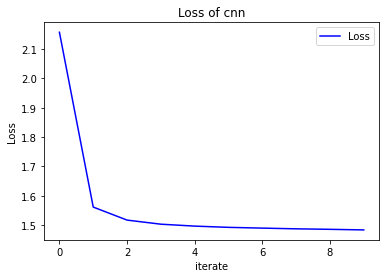

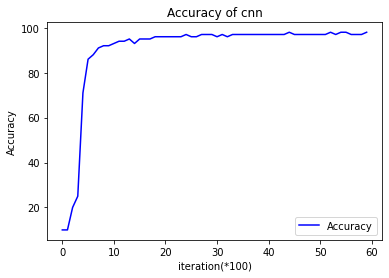

In [25]:
cnn1 = play(dataset='mnist', method='cnn', epochs=10)
cnn1.train()

In [ ]:
smr2 = play(dataset='cifar', method='lr', epochs=200)
smr2.train()

Files already downloaded and verified
Files already downloaded and verified
Iteration: 500. Loss: 2.1222457885742188. Accuracy: 28.
Iteration: 1000. Loss: 1.9725760221481323. Accuracy: 31.
Iteration: 1500. Loss: 2.017047643661499. Accuracy: 33.
Iteration: 2000. Loss: 2.0040371417999268. Accuracy: 33.
Iteration: 2500. Loss: 2.019911289215088. Accuracy: 34.
Iteration: 3000. Loss: 1.9115569591522217. Accuracy: 35.
Iteration: 3500. Loss: 1.8816978931427002. Accuracy: 35.
Iteration: 4000. Loss: 1.8247560262680054. Accuracy: 35.
Iteration: 4500. Loss: 1.929039478302002. Accuracy: 35.
Iteration: 5000. Loss: 1.8258510828018188. Accuracy: 36.
Iteration: 5500. Loss: 1.8018908500671387. Accuracy: 36.
Iteration: 6000. Loss: 1.7542357444763184. Accuracy: 36.
Iteration: 6500. Loss: 1.917433500289917. Accuracy: 36.
Iteration: 7000. Loss: 1.7349516153335571. Accuracy: 37.
Iteration: 7500. Loss: 1.8130934238433838. Accuracy: 37.
Iteration: 8000. Loss: 1.8318109512329102. Accuracy: 37.
Iteration: 8500. 

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration: 500. Loss: 2.302243709564209. Accuracy: 9.
Iteration: 1000. Loss: 2.3022301197052. Accuracy: 11.
Iteration: 1500. Loss: 2.301547050476074. Accuracy: 17.
Iteration: 2000. Loss: 2.2530274391174316. Accuracy: 21.
Iteration: 2500. Loss: 2.203512668609619. Accuracy: 25.
Iteration: 3000. Loss: 2.1403465270996094. Accuracy: 30.
Iteration: 3500. Loss: 2.162090301513672. Accuracy: 31.
Iteration: 4000. Loss: 2.0735480785369873. Accuracy: 34.
Iteration: 4500. Loss: 2.050729274749756. Accuracy: 36.
Iteration: 5000. Loss: 2.0655405521392822. Accuracy: 37.
Iteration: 5500. Loss: 2.0567219257354736. Accuracy: 42.
Iteration: 6000. Loss: 2.0201494693756104. Accuracy: 43.
Iteration: 6500. Loss: 2.0876541137695312. Accuracy: 42.
Iteration: 7000. Loss: 2.00262451171875. Accuracy: 45.
Iteration: 7500. Loss: 2.0203957557678223. Accuracy: 46.
Iteration: 8000. Loss: 1.994215726852417. Accuracy: 47.
Iteration: 8500. Loss: 2.0016345977783203. Accuracy: 48.
Iteration: 9000. Loss: 1.987473487854004. Ac

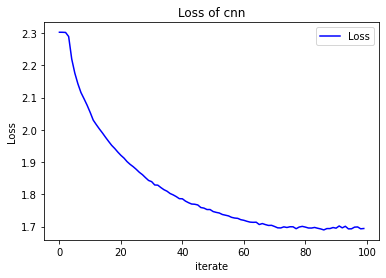

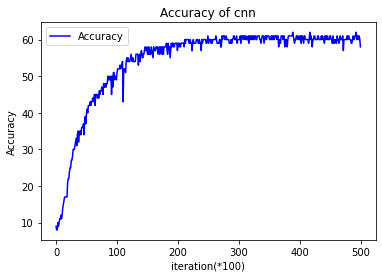

In [9]:
mn = play(dataset='cifar', method='cnn', epochs=100)
mn.train()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Iteration: 600. Loss: 1.8094494342803955. Accuracy: 78.
Iteration: 1200. Loss: 1.7086894512176514. Accuracy: 83.
Iteration: 1800. Loss: 1.5551140308380127. Accuracy: 90.
Iteration: 2400. Loss: 1.5582963228225708. Accuracy: 91.
Iteration: 3000. Loss: 1.5596327781677246. Accuracy: 92.
Iteration: 3600. Loss: 1.5538356304168701. Accuracy: 92.
Iteration: 4200. Loss: 1.5420411825180054. Accuracy: 92.
Iteration: 4800. Loss: 1.4877322912216187. Accuracy: 93.
Iteration: 5400. Loss: 1.521370530128479. Accuracy: 94.
Iteration: 6000. Loss: 1.520586371421814. Accuracy: 94.


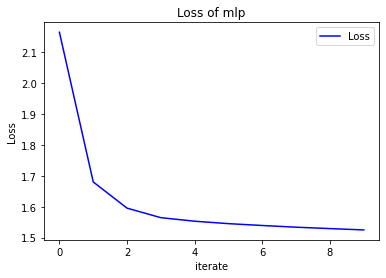

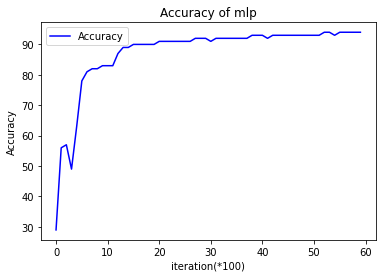

In [10]:
mn = play(dataset='mnist', method='mlp', epochs=10)
mn.train()

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration: 500. Loss: 2.185699462890625. Accuracy: 25.
Iteration: 1000. Loss: 2.1518900394439697. Accuracy: 30.
Iteration: 1500. Loss: 2.129945755004883. Accuracy: 33.
Iteration: 2000. Loss: 2.103560209274292. Accuracy: 35.
Iteration: 2500. Loss: 2.07816219329834. Accuracy: 37.
Iteration: 3000. Loss: 2.0806028842926025. Accuracy: 34.
Iteration: 3500. Loss: 2.1045339107513428. Accuracy: 38.
Iteration: 4000. Loss: 2.03104305267334. Accuracy: 39.
Iteration: 4500. Loss: 2.037970542907715. Accuracy: 40.
Iteration: 5000. Loss: 2.1087584495544434. Accuracy: 40.
Iteration: 5500. Loss: 2.0761237144470215. Accuracy: 40.
Iteration: 6000. Loss: 1.956323504447937. Accuracy: 42.
Iteration: 6500. Loss: 2.085827350616455. Accuracy: 39.
Iteration: 7000. Loss: 2.0826635360717773. Accuracy: 41.
Iteration: 7500. Loss: 1.9102206230163574. Accuracy: 44.
Iteration: 8000. Loss: 2.0302085876464844. Accuracy: 43.
Iteration: 8500. Loss: 1.9751476049423218. Accuracy: 45.
Iteration: 9000. Loss: 2.0056233406066895.

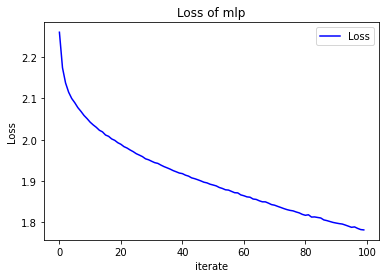

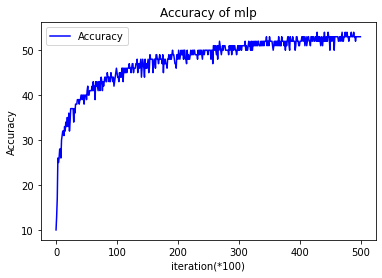

In [13]:
mn = play(dataset='cifar', method='mlp', epochs=100)
mn.train()

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration: 500. Loss: 2.2831780910491943. Accuracy: 10.
Iteration: 1000. Loss: 2.203763484954834. Accuracy: 25.
Iteration: 1500. Loss: 2.1525187492370605. Accuracy: 28.
Iteration: 2000. Loss: 2.1009469032287598. Accuracy: 30.
Iteration: 2500. Loss: 2.1107420921325684. Accuracy: 33.
Iteration: 3000. Loss: 2.194105386734009. Accuracy: 31.
Iteration: 3500. Loss: 2.1311850547790527. Accuracy: 35.
Iteration: 4000. Loss: 2.0433664321899414. Accuracy: 35.
Iteration: 4500. Loss: 2.042879581451416. Accuracy: 38.
Iteration: 5000. Loss: 2.034593343734741. Accuracy: 38.
Iteration: 5500. Loss: 2.1169939041137695. Accuracy: 39.
Iteration: 6000. Loss: 2.0581932067871094. Accuracy: 40.
Iteration: 6500. Loss: 2.059532880783081. Accuracy: 40.
Iteration: 7000. Loss: 2.0546205043792725. Accuracy: 38.
Iteration: 7500. Loss: 2.006317615509033. Accuracy: 42.
Iteration: 8000. Loss: 2.0592968463897705. Accuracy: 42.
Iteration: 8500. Loss: 1.9758055210113525. Accuracy: 44.
Iteration: 9000. Loss: 2.0011124610900

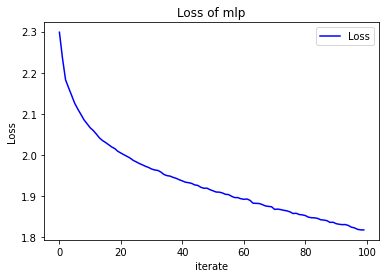

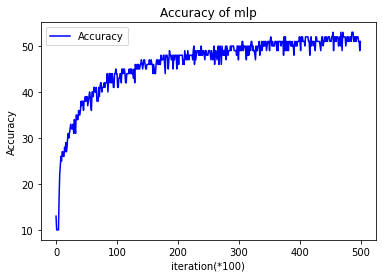

In [14]:
mlp2 = play(dataset='cifar', method='mlp', epochs=100)
mlp2.train()